In [1]:
!pip install librosa scikit-learn pandas numpy soundfile joblib matplotlib IPython seaborn

In [2]:
import os
import glob
import librosa
import soundfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import tempfile
import shutil
from IPython.display import Audio, display
import ipywidgets as widgets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

In [3]:
# Emotion mapping
emotions_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised',
    'neu': 'neutral', 'hap': 'happy', 'ang': 'angry', 'sad': 'sad',
    'dis': 'disgust', 'fea': 'fearful', 'sur': 'surprised', 'calm': 'calm'
}
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

In [4]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sf:
        X = sf.read(dtype="float32")
        sample_rate = sf.samplerate
        result = np.array([])

        if chroma or mel:
            stft = np.abs(librosa.stft(X))

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_feat))

        if mel:
            mel_feat = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_feat))

    return result


In [5]:
dataset_path = r"C:\Users\jayad\rav" 

In [6]:
def load_data(test_size=0.2):
    x, y = [], []
    for folder in glob.glob(os.path.join(dataset_path, 'Actor_*')):
        for file in glob.glob(os.path.join(folder, '*.wav')):
            try:
                emotion = emotions_map.get(os.path.basename(file).split("-")[2])
                if emotion not in observed_emotions:
                    continue
                features = extract_feature(file)
                x.append(features)
                y.append(emotion)
            except Exception as e:
                print(f"Skipped {file}: {e}")
    x, y = np.array(x), np.array(y)
    return train_test_split(x, y, test_size=test_size, random_state=42)


In [7]:
x_train, x_test, y_train, y_test = load_data()

Skipped C:\Users\jayad\rav\Actor_01\03-01-02-01-01-02-01.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Skipped C:\Users\jayad\rav\Actor_05\03-01-02-01-02-02-05.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Skipped C:\Users\jayad\rav\Actor_20\03-01-03-01-02-01-20.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Skipped C:\Users\jayad\rav\Actor_20\03-01-06-01-01-02-20.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)


In [8]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [9]:
selector = SelectKBest(score_func=f_classif, k=100)
x_train_sel = selector.fit_transform(x_train, y_train)
x_test_sel = selector.transform(x_test)


In [10]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


In [11]:
svm = GridSearchCV(SVC(probability=True), {'C': [1, 10], 'kernel': ['linear', 'rbf']}, cv=3)
svm.fit(x_train_sel, y_train_enc)
y_pred_svm = svm.predict(x_test_sel)
svm_acc = accuracy_score(y_test_enc, y_pred_svm)

In [12]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(x_train_sel, y_train_enc)
y_pred_mlp = mlp.predict(x_test_sel)
mlp_acc = accuracy_score(y_test_enc, y_pred_mlp)

In [13]:
os.makedirs("models", exist_ok=True)
if mlp_acc > svm_acc:
    best_model = mlp
    model_name = "MLPClassifier"
    best_acc = mlp_acc
else:
    best_model = svm
    model_name = "SVM"
    best_acc = svm_acc

joblib.dump(best_model, "models/best_model.pkl")
joblib.dump(label_encoder, "models/label_encoder.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(selector, "models/selector.pkl")

print(f"✅ Best Model: {model_name} | Accuracy: {best_acc * 100:.2f}%")

✅ Best Model: MLPClassifier | Accuracy: 77.12%


In [14]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


📊 SVM Accuracy: 73.86%
              precision    recall  f1-score   support

        calm       0.83      0.85      0.84        40
     disgust       0.64      0.74      0.68        34
     fearful       0.74      0.83      0.79        42
       happy       0.73      0.51      0.60        37

    accuracy                           0.74       153
   macro avg       0.74      0.73      0.73       153
weighted avg       0.74      0.74      0.73       153



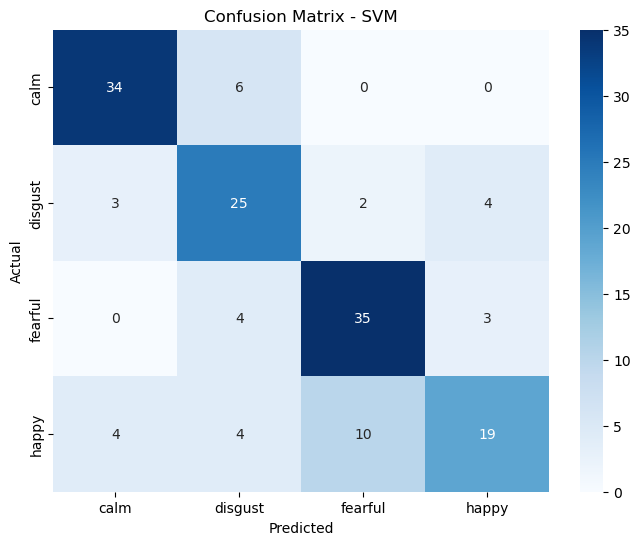


📊 MLPClassifier Accuracy: 77.12%
              precision    recall  f1-score   support

        calm       0.95      0.88      0.91        40
     disgust       0.68      0.79      0.73        34
     fearful       0.74      0.74      0.74        42
       happy       0.74      0.68      0.70        37

    accuracy                           0.77       153
   macro avg       0.77      0.77      0.77       153
weighted avg       0.78      0.77      0.77       153



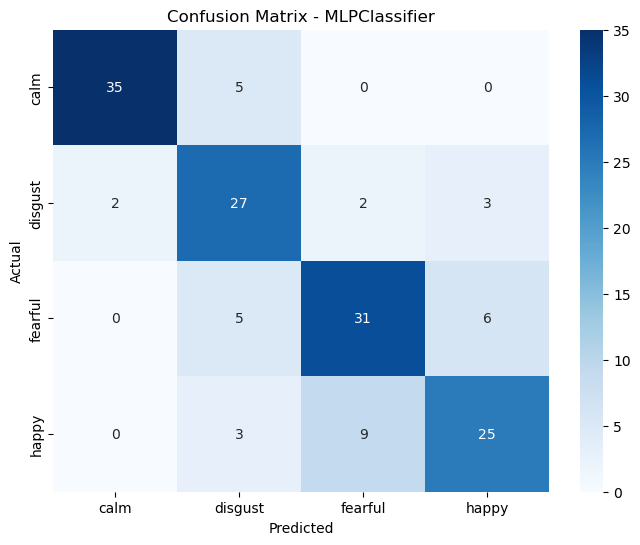

In [15]:
for name, pred in zip(["SVM", "MLPClassifier"], [y_pred_svm, y_pred_mlp]):
    print(f"\n📊 {name} Accuracy: {accuracy_score(y_test_enc, pred) * 100:.2f}%")
    print(classification_report(y_test_enc, pred, target_names=label_encoder.classes_))
    plot_confusion_matrix(y_test_enc, pred, name)

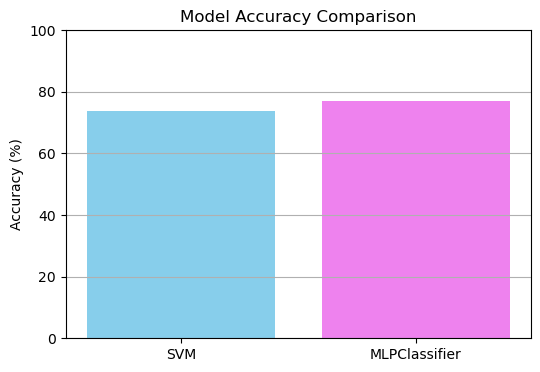

In [43]:
plt.figure(figsize=(6, 4))
plt.bar(['SVM', 'MLPClassifier'], [svm_acc * 100, mlp_acc * 100], color=['skyblue', 'violet'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 100])
plt.grid(True, axis='y')
plt.show()

In [45]:
# Required Imports
import os
import numpy as np
import librosa
import soundfile
import joblib
from IPython.display import Audio, display

# Load feature extraction function
def extract_features(file_name, mfcc=True, chroma=True, mel=True):
    try:
        with soundfile.SoundFile(file_name) as sf:
            X = sf.read(dtype="float32")
            sample_rate = sf.samplerate
            result = np.array([])

            if chroma or mel:
                stft = np.abs(librosa.stft(X))

            if mfcc:
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                result = np.hstack((result, mfccs))

            if chroma:
                chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
                result = np.hstack((result, chroma_feat))

            if mel:
                mel_feat = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
                result = np.hstack((result, mel_feat))

        return result
    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return None


In [47]:
def predict_emotion(file_path):
    try:
        # Load all trained components
        model = joblib.load("models/best_model.pkl")
        label_encoder = joblib.load("models/label_encoder.pkl")
        scaler = joblib.load("models/scaler.pkl")
        selector = joblib.load("models/selector.pkl")

        # Feature extraction
        features = extract_features(file_path)
        if features is None:
            print("⚠️ Feature extraction failed.")
            return None, None

        features = features.reshape(1, -1)
        features = scaler.transform(features)
        features = selector.transform(features)

        # Predict
        predicted_class_index = model.predict(features)[0]
        predicted_emotion = label_encoder.inverse_transform([predicted_class_index])[0]

        # Compute confidence using probability for predicted class
        if hasattr(model, "predict_proba"):
            probabilities = model.predict_proba(features)[0]
            confidence = float(probabilities[predicted_class_index]) * 100
        else:
            confidence = None  # for models without predict_proba

        # Output
        print(f"\n🎙️ Predicted Emotion: {predicted_emotion}")
        if confidence is not None:
            print(f"📈 Confidence: {confidence:.2f}%")
        else:
            print("ℹ️ Confidence not available for this model.")

        return predicted_emotion, confidence

    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None, None


In [49]:
def test_audio_file():
    file_path = input("Enter path to the audio file (e.g., C:/path/file.wav): ").strip().strip('"')

    try:
        print("\n🔊 Playing audio...")
        display(Audio(filename=file_path))
    except Exception as e:
        print(f"Could not play audio: {e}")

    predict_emotion(file_path)

# Run it
test_audio_file()

Enter path to the audio file (e.g., C:/path/file.wav):  "C:\Users\jayad\OneDrive\Desktop\ser\rav\Actor_11\03-01-03-02-01-01-11.wav"



🔊 Playing audio...



🎙️ Predicted Emotion: happy
📈 Confidence: 99.80%
